In [2]:
%load_ext autoreload
%autoreload 2

from pyspark.sql import SparkSession

spark = SparkSession. \
    builder. \
    appName('my-demo-spark-job'). \
    getOrCreate()

spark = spark.newSession()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")


import numpy as np
import pandas as pd
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
import mplfinance as mpf
from pyspark.sql.functions import explode
from scipy.ndimage import gaussian_filter


from delta.tables import *
import random
df = spark.read.format("delta").load("/Users/bowles/stocks/delta2")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import mplfinance as mpf
pred_col='gauss5'
plt.style.use('ggplot')
def plot_fillin(datedf, pred_col):
    y1values = datedf['Close'].values
    y2value  = datedf['Low'].min()
    # where_values = getall_where_values(datedf, runner, pred)
    # fill_between=dict(y1=y1values,y2=y2value,where=where_values,alpha=0.5,color='g')
    fig, axlis = mpf.plot(datedf,type='line', figsize=(30, 20),  show_nontrading=True, 
             # addplot=plots, 
                          returnfig=True)
    ticks = pd.date_range(min(datedf.index), max(datedf.index), freq='20T')
    _ = axlis[1].xaxis.set_ticks(ticks)
    return axlis

In [94]:
!pip install --upgrade mplfinance

[autoreload of psutil failed: Traceback (most recent call last):
  File "/Users/bowles/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/bowles/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/Users/bowles/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/bowles/opt/anaconda3/lib/python3.9/site-packages/psutil/__init__.py", line 237, in <module>
    raise ImportError(msg)
ImportError: version conflict: '/Users/bowles/opt/anaconda3/lib/python3.9/site-packages/psutil/_psutil_osx.cpython-39-darwin.so' C extension modu

/var/folders/zz/74fvcj6j38zg9q52mq_dt89c0000gp/T/ipykernel_2400/78220886.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go" (-> marker='o'). The keyword argument will take precedence.
  ax[0].plot(datedf['temp'], 'go', marker='.', markersize=1)
/var/folders/zz/74fvcj6j38zg9q52mq_dt89c0000gp/T/ipykernel_2400/78220886.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax[0].plot(datedf['gauss3'], 'ko', marker='.', markersize=1)
/var/folders/zz/74fvcj6j38zg9q52mq_dt89c0000gp/T/ipykernel_2400/78220886.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax[0].plot(datedf['adjustv9'], 'ro', marker='.', markersize=1)


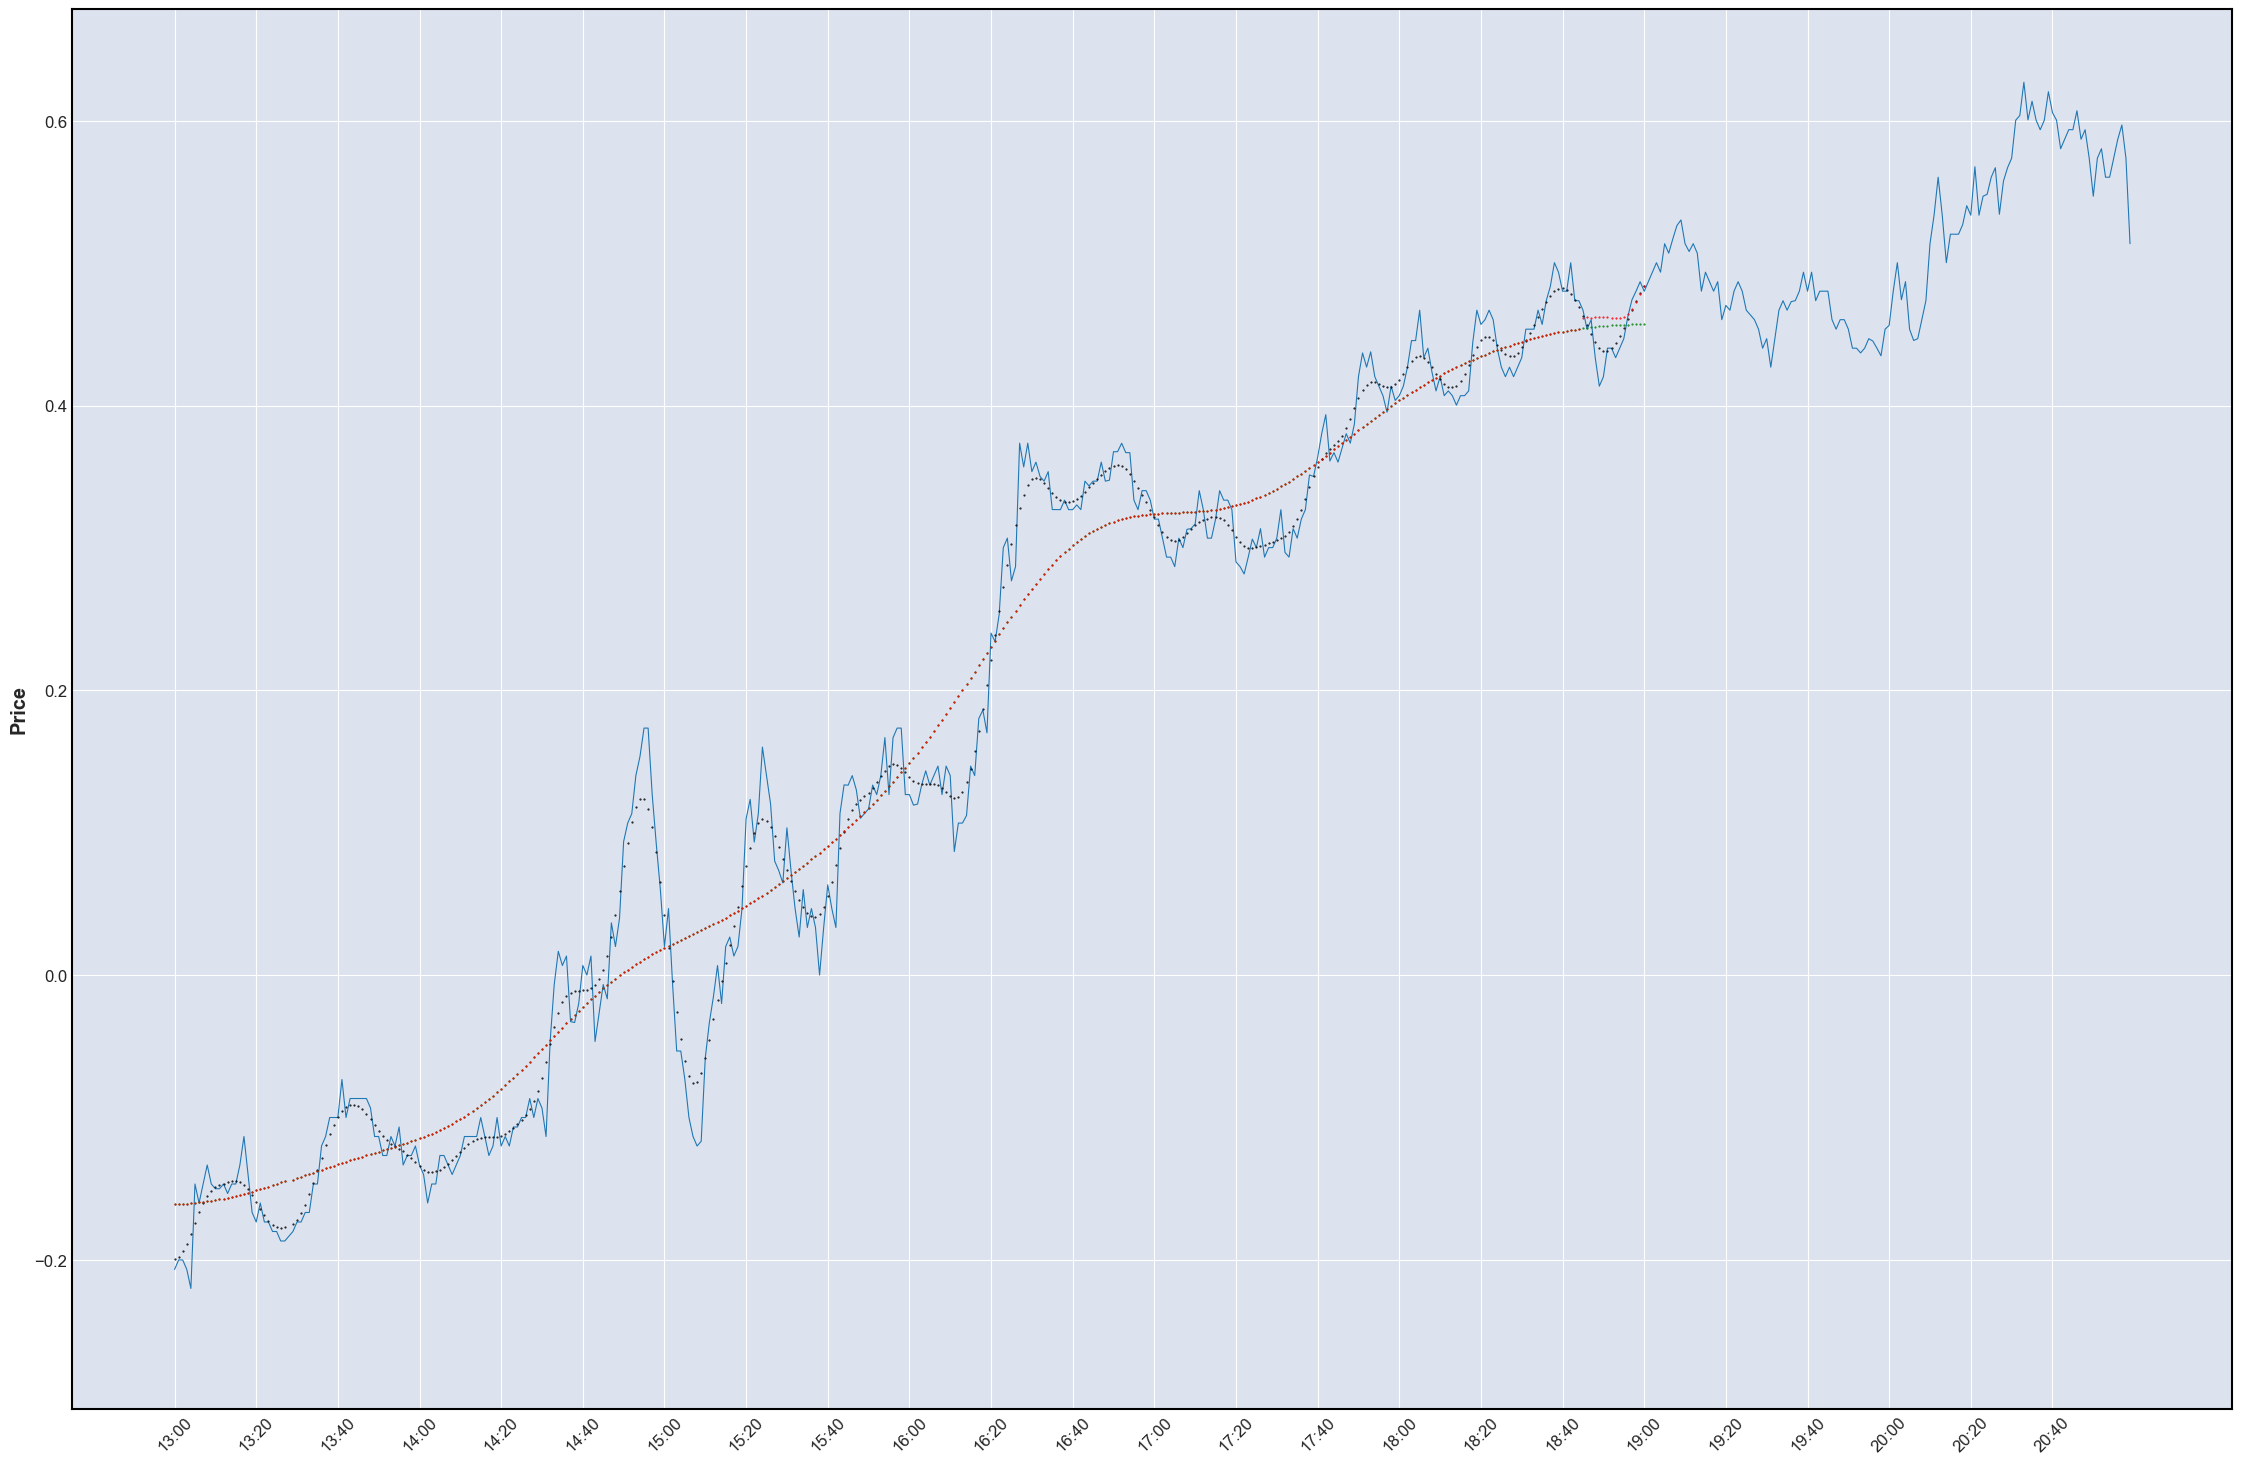

In [5]:
dates = df.select("Date").distinct().toPandas()['Date'].tolist()
df.filter(f"Date == '{random.choice(dates)}'").select('*').toPandas()
date = '2013-01-29' # random.choice(dates) #
datedf = df.filter(f"Date == '{date}'").select('*').toPandas()
datedf.set_index(pd.to_datetime(datedf['Datetime'],infer_datetime_format=True), inplace=True)
datedf.sort_index(inplace=True)

ax = plot_fillin(datedf, 'gauss16')
cutoff = 360
def nanarray(n):
    a = np.empty((n,))
    a[:] = np.nan
    return a

datedf = datedf.iloc[:cutoff, :]
sm9 = gaussian_filter(datedf.iloc[:cutoff, :]['Close'], 20)
vector9 = np.concatenate([sm9, nanarray(len(datedf) - cutoff)])
datedf['temp'] = vector9
ax[0].plot(datedf['temp'], 'go', marker='.', markersize=1)
ax[0].plot(datedf['gauss3'], 'ko', marker='.', markersize=1)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def adjust_end(vector):
    def getweights():
        weights = []
        for mu in list(np.linspace(2, 12, 16)):
            n, bins =np.histogram(np.random.normal(mu, 1, 1000),  bins=range(10))
            temp = [i*j for i, j in zip(bins, n)]
            weights.append([m / sum(temp) for m in temp][1:])
        return weights
    
    weights = getweights()
    
    vweights = {n: 'gauss' + str(n + 2) for n in range(8)}
    for n in range(len(weights)): # going backwards from back of list
        weights_i = weights[n] # weights list starts at end
        values = [datedf[vweights[b]].tolist()[-(n + 1)] for b in range(8)]
        value = sum([i* j for i, j in zip(weights_i, values)])
        vector[-(n + 1)] = value
        
    return vector

datedf['adjustv9'] = np.concatenate([adjust_end(sm9), nanarray(len(datedf) - cutoff)]) 
ax[0].plot(datedf['adjustv9'], 'ro', marker='.', markersize=1)


In [ ]:
weights = {0: {'gauss2': 0.8, 'gauss3': 0.15, 'gauss4': 0.04, 'gauss5': 0.01},
           1: {'gauss2': 0.1, 'gauss3': 0.7, 'gauss4': 0.1, 'gauss5': 0.05, 'gauss6': 0.05},
           2: {'gauss2': 0.03, 'gauss3': 0.07, 'gauss4': 0.5, 'gauss5': 0.3, 'gauss6': 0.07, 'gauss7': 0.03},
           3: {'gauss3': 0.05, 'gauss4': 0.15, 'gauss5': 0.5, 'gauss6': 0.2, 'gauss7': 0.05, 'gauss8': 0.05},
           4: {'gauss4': 0.05, 'gauss5': 0.15, 'gauss6': 0.3, 'gauss7': 0.4, 'gauss8': 0.07, 'gauss9': 0.03},
           5: {'gauss5': 0.1, 'gauss6': 0.5, 'gauss7': 0.4, 'gauss8': 0.07, 'gauss9': 0.03},
           
           

In [331]:

# delta_path = "/Users/bowles/stocks/delta2"
def gauss(n, datedf):
    return gaussian_filter(datedf['Close'], n)




from add_feature import add_feature3

for i in [10]:
    add_feature3(partial(gauss,i), 'gauss' + str(i), "/Users/bowles/stocks/delta2")

22/11/27 21:20:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


/Users/bowles/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/group_ops.py:98: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [84]:
len(datedf['Close'])

776

In [8]:
df = spark.read.format("delta").load("/Users/bowles/stocks/delta2")
df.columns

['Datetime',
 'Timestamp',
 'Volume',
 'Date',
 'Close',
 'Close_o',
 'Low',
 'Low_o',
 'High',
 'High_o',
 'Open',
 'Open_o',
 'ground_truth',
 'slope_ground_truth',
 'r',
 'gauss3']

In [367]:
vector = datedf['gauss9']

vweights = {n: 'gauss' + str(n + 2) for n in range(8)}
for n in range(len(weights)): # going backwards from back of list
    weights_i = weights[n] # weights list starts at end
    newvals = []
    for b in range(len(weights_i)):
        newvals.append(weights_i[b] * datedf[vweights[b]].tolist()[-(n + 1)]  )
    vector[-(n + 1)] = sum(newvals)

/var/folders/zz/74fvcj6j38zg9q52mq_dt89c0000gp/T/ipykernel_20387/1297226274.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vector[-(n + 1)] = sum(newvals)


In [368]:
vweights

{0: 'gauss2',
 1: 'gauss3',
 2: 'gauss4',
 3: 'gauss5',
 4: 'gauss6',
 5: 'gauss7',
 6: 'gauss8',
 7: 'gauss9'}